# Boson Sampling

We are interested to simulate a boson sample with 14 photons and 60 modes, order of size comparable to what was done in *Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a* $10^{14}$*-Dimensional Hilbert Space* <a href="#references">[1]</a>

In [1]:
from IPython import display
from collections import Counter
from tabulate import tabulate
from tqdm.auto import tqdm
import gzip
import pickle
import time

import sympy as sp
import random

import perceval as pcvl
import perceval.components.base_components as comp

We define all the needed values below. 

## Perfect Boson sampling

In [2]:
n = 14       #number of photons at the input
m = 60       #number of modes
N = 5000000  #number of samplings

### Generating a Haar random Unitary with Perceval

In [3]:
Unitary_60 = pcvl.Matrix.random_unitary(m) #creates a random unitary of dimension 60

### A possible linear circuit realization of such matrix would be the following.

Here we define a 2-mode unitary circuit that we can use to decompose the 60 mode unitary

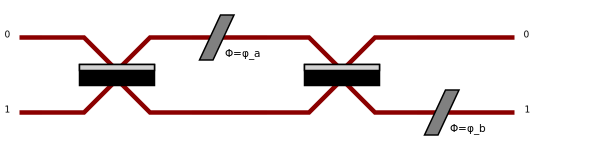

In [4]:
mzi = (comp.SimpleBS() // (0, comp.PS(phi=pcvl.Parameter("φ_a")))
       // comp.SimpleBS() // (1, comp.PS(phi=pcvl.Parameter("φ_b"))))
pcvl.pdisplay(mzi)

Let us decompose the unitary into a Reck's type circuit <a href="#references">[2]</a> - this makes a huge circuit...

In [5]:
Linear_Circuit_60 = pcvl.Circuit.decomposition(Unitary_60, mzi,
                                               phase_shifter_fn=comp.PS,
                                               shape="triangle")

### Running Simulation

Now we choose the way to perform the simulation with Perceval. The number of photons is within what we could simulate with a `Naive` backend (see [here](https://perceval.quandela.net/docs/backends.html#naive)), however, the output space is far too big just to enumerate and store the states - so let us go with sampling using `CliffordClifford2017` backend (see [here](https://perceval.quandela.net/docs/backends.html#cliffordclifford2017)).

In [6]:
Sampling_Backend = pcvl.BackendFactory().get_backend("CliffordClifford2017")

Select a random input:

In [7]:
#one can choose which mode he/she wants at input, or we can choose it randomly 
def Generating_Input(n, m, modes = None):
    "This function randomly chooses an input with n photons in m modes."
    if modes == None :
        modes = sorted(random.sample(range(m),n))
    state = "|"
    for i in range(m):
        state = state + "0"*(1 - (i in modes)) +"1"*(i in modes)+ ","*(i < m-1)
    return pcvl.BasicState(state + ">")

input_state = Generating_Input(n, m)
print("The input state: ", input_state)

The input state:  |1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0>


Just to see that it outputs a statevectors of n photon(s) in m modes.

In [8]:
print("The sampled outputs are:")
for _ in range(10): 
    print(Sampling_Backend(Unitary_60).sample(input_state))

The sampled outputs are:
|0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,2,0,0>
|0,0,1,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,1,0>
|0,1,0,0,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0>
|0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0>
|0,0,1,0,1,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0>
|0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0>
|0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0>
|0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2,0>
|0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,0>
|1,1,1,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0>


We carry out the sampling, we do it N times, it will take some time, let us save the results to a file:

In [9]:
# if we want to launch parallel process
worker_id=1

#store the input and the unitary
with open("%dphotons_%dmodes_%dsamples-worker%s-unitary.pkl" %(n,m,N,worker_id), 'wb') as f:
    pickle.dump(Unitary_60, f)

with open("%dphotons_%dmodes_%dsamples-worker%s-inputstate.pkl" %(n,m,N,worker_id), 'w') as f:
    f.write(str(input_state)+"\n")


with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz" %(n,m,N,worker_id), 'wb') as f:
    start = time.time()
    for i in range(N):
        f.write((str(Sampling_Backend(Unitary_60).sample(pcvl.BasicState(input_state)))+"\n").encode());
    end = time.time()
    f.write(str("==> %d\n" % (end-start)).encode())
f.close()

A little after (4 hours on a 3.1GHz Intel) - we do have 5M samples. We launched this on 32 threads for 2 days and collected 300 batches of 5M samples

Let us analyze the K-first mode bunching on these samples

In [10]:
import gzip

In [11]:
worker_id = 1
count = 0
bunching_distribution = Counter()

with gzip.open("%dphotons_%dmodes_%dsamples-worker%s-samples.txt.gz"%(n,m,N,worker_id), "rt") as f:
    for l in f:
        l = l.strip()
        if l.startswith("|") and l.endswith(">"):
            try:
                st = pcvl.BasicState(l)
                count+=1
                bunching_distribution[st.photon2mode(st.n-1)]+=1
            except Exception:
                pass
print(count, "samples")
print("Bunching Distribution:", "\t".join([str(bunching_distribution[k]) for k in range(m)]))

5000 samples
Bunching Distribution: 0	0	1	1	2	7	11	22	40	74	164	198	96	257	237	694	559	509	1713	415


These numbers have been used on 300 samples for certification - see our article on Perceval for more details.

## Boson sampling with non perfect sources

Let us explore around performing Boson sampling with a non perfect source. We declare a source with 90% brightness and purity.

In [12]:
source = pcvl.Source(brightness=0.90, purity=0.9)
QPU = pcvl.Processor({1:source,2:source, 3:source }, Linear_Circuit_60)

We can see what is the source distribution, so how likely a state at the input of the linear circuit will be.

In [13]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-7, max_v=20)

state,probability
"|0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.531441
"|0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.06561
"|0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.06561
"|0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.06561
"|0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.059049
"|0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.059049
"|0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.059049
"|0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.0081
"|0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.0081
"|0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0>",0.0081


[1]: Hui Wang, et al. Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a $10^{14}$-Dimensional Hilbert Space. [Physical Review Letters](https://link.aps.org/doi/10.1103/PhysRevLett.123.250503), 123(25):250503, December 2019. Publisher: American Physical Society.

[2]: Michael Reck, Anton Zeilinger, Herbert J Bernstein, and Philip Bertani. Experimental realization of any discrete unitary operator. [Physical review letters](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58), 73(1):58, 1994.